# Schelling Segregation

## Conceptual description
The basic idea of Schelling's seggregation model is quite straight forward. Imagine we have agents organized on a grid. Agents are either red or blue. Agents prefer to be in an environment with agents of the same color, but they are quite tolerant. If the fraction of neighbors of a different color is higher than this tolerance threshold, the agent moves to another free grid cell. At what level of tolerance does segregation occur? 

Given this basic description, the model is composed of a grid, with one agent per grid cell. This grid is not completely filled because we need to have free space to where an agent can move. Each agent has a tolerance level, and checks when asked if the fraction of neighbors that is of the different type is higher than this tolerance level. 

## Implementing a first version of the model

### Assignment

1. What classes do you need for this model? And what are the key attributes for each of these classes?



You need 

**SchellingModel**
* grid
* schedule
* initial ratio between agent colors

**SchellingAgent**
* color
* tolerance threshold

## Schedulers
A key issue with the Schelling model, and a key way in which this model is different from the various versions of the Axelrod model is that a step by a given agent can change the local environment. Imagine that a given agent checks its neighborhood, decided that the number of neighbors of a different color is higher than its threshold, and thus decides to move to an empty spot. This move changes the neighborhood the agent is leaving. It also changes the neighborhood the agent is moving to. Depending on the order in which agents are activated (i.e. the `step` method is called) different dynamic patterns can occur.

This agent activation is typically handled through a so-called scheduler. In the Axelrod method, we did this ourself by having a list or set of agents as an attribute on the model. However, we might want to use a more sophisticated class to handle agent activation. MESA comes with a number of schedulers. 

*  **BaseScheduler**; the base scheduler is nothing but a list and we activate the agents based on the unique ID they have. Internally, base scheduler uses an `OrderedDict`, orded by `agent.unique_id`. 
* **RandomActivation**; shuffle all agents before activating them one by one. This is the most often used scheduler in all agent based models. It does introduce yet another form of stochasticity in the model, thus making it necessary to run multiple replications and carefully control the random seed.
* **SimultaneousActivation**; a more complicated activation for mimicking all agents moving simultaneously. Rather than having a single step method on an agent, each agent has a staging method and an execution method. You first stage all agents, and then execute all agents. Staging in the context of Schelling Segregation means deciding to move or not. Executing means making the move. So SimultaneousActivation partly solves the path dependency problem mentioned above. Partly, because when moving only a single agent can occupy a given free spot.
* **StagedActivation**; A more complicated activation system were agents have not a single step method, but multiple phases of action were each phase needs to be completed for all agents, before moving to the next method. Basically, this is an even more sophisticated extension of SimultaneousActivation.

A model typically has only a single scheduler for all agents, but it is also possible to have multiple schedulers for different agent types.

## Assignment 1

Below, I have given the outline of the model, we are going to implement this now. First, implement the ``__init__`` of the model. It is indicated below with the `...`. A hint regarding attributes can be found in the docstring. The code is very similar to the initialization used for the spatial version of the Axelrod model. After the code block, there is some test code to help you check if your code is working.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

from enum import Enum

class Color(Enum):
    RED = 1 # minority color
    BLUE = 2 # majority color

class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : int
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=4, seed=None):
        super().__init__(seed=seed)
        
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_fraction = minority_fraction

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < self.density:
                if self.random.random() < self.minority_fraction:
                    agent_color = Color.RED
                else:
                    agent_color = Color.BLUE
                    
                print(agent_color)
                break

                agent = SchellingAgent((x, y), self, agent_color, tolerance_threshold)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()


class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : int
    
    """

    def __init__(self, pos, model, color, tolerance_threshold):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold

    def step(self):
        raise NotImplementedError


In [4]:
import random
random.choice?

Signature: random.choice(seq)
Docstring: Choose a random element from a non-empty sequence.
File:      ~/opt/anaconda3/lib/python3.8/random.py
Type:      method



To test the implementation, we can visualize the grid. To do this, we are creating a numpy array with zeros of the same width and height as the model grid. Next, we iterate over the grid and fill in this empty array. We use a value of 3 for an empty cell, and the color number from the `Color` enum class. 

We can easily visualize the filled in numpy array using matplotlib (e.g. matshow) or seaborn's heatmap. To make the figure a bit nicer, I use a few tricks. First, I am getting a color map from seaborn. This color map is generated by the [colorbrewer](https://colorbrewer2.org/) website. As you can see on this website, the `Set1` colormap has red as 1, blue as 2, and 3 as green. This matches perfectly with the numbers used in filling in the numpy array (and why we used 3 for the empty cells). Second, I like to have a nice equally spaced figure, which you can do by setting the aspect of the axes to equal. 



Color.BLUE


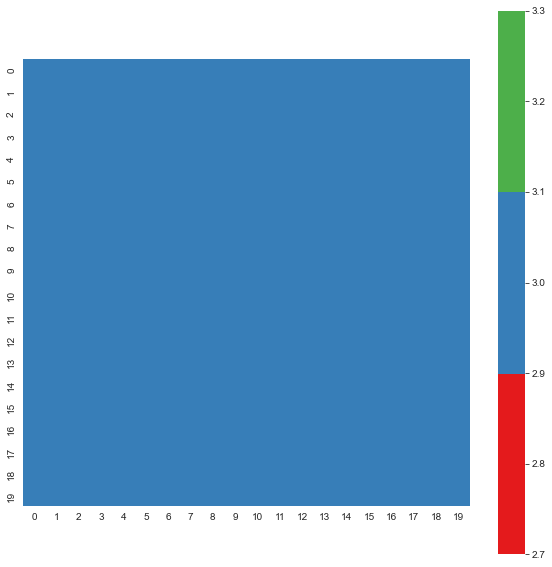

In [2]:
model = Schelling()


def plot_model(model, ax, colors):
    grid = np.zeros((model.height, model.width))

    for (cell, i, j) in model.grid.coord_iter():
        value = 3
        if cell is not None:
            value = cell.color.value
        grid[i, j] = value
    sns.heatmap(grid, ax=ax, cmap=colors)

fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette('Set1', 3)
ax.set_aspect('equal')

plot_model(model, ax, colors)

plt.show()

## Assignment 2
The next step is to implement the logic in the step method of the agent. This is straight forward, we iterate over our neighbors. If our neighbor is of a different color, we increment a counter. After having checked our entire neighborhood, the agent compares this counter with its tolerance threshold. If the number of neighbors of a different color is higher than the threshold, the agent will move. For now, we will use the `move_to_empty` method on the grid for this. 

Regarding neighborhood, assume that we include also our diagonal neighbors.

Go ahead and implement the model.

Test code is provided below.

In [10]:
class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    """

    def __init__(self, pos, model, color, tolerance_threshold):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold

    def step(self):
        different = 0
        for neighbor in self.model.grid.neighbor_iter(self.pos, moore=True):
            if neighbor.color != self.color:
                different += 1

        # If unhappy, move:
        if different > self.tolerance_threshold:
            self.model.grid.move_to_empty(self)

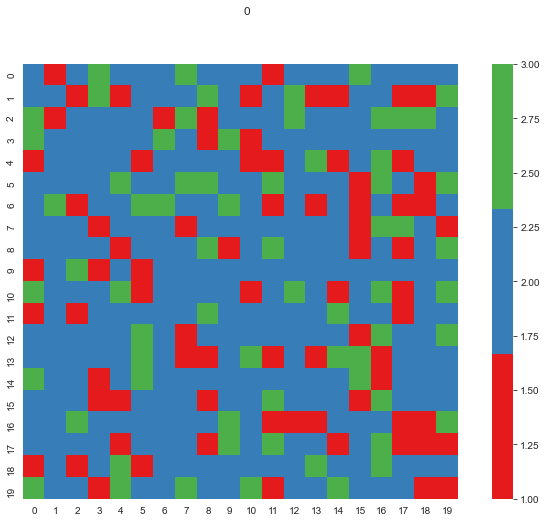

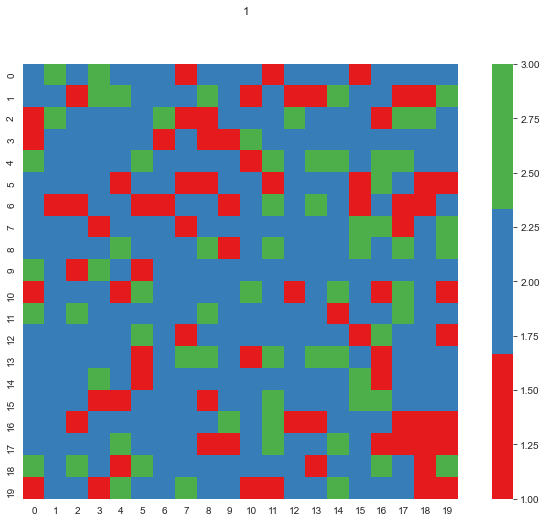

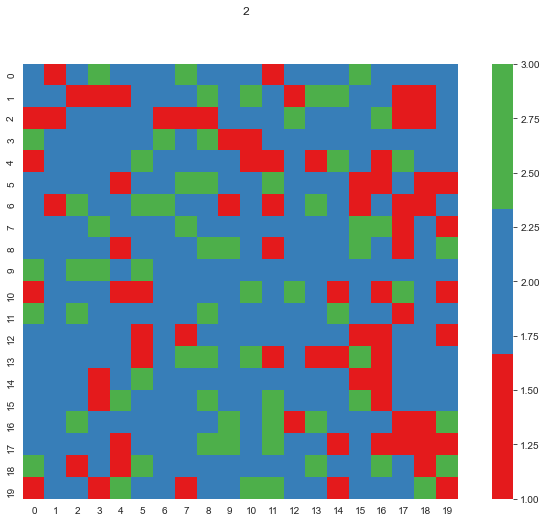

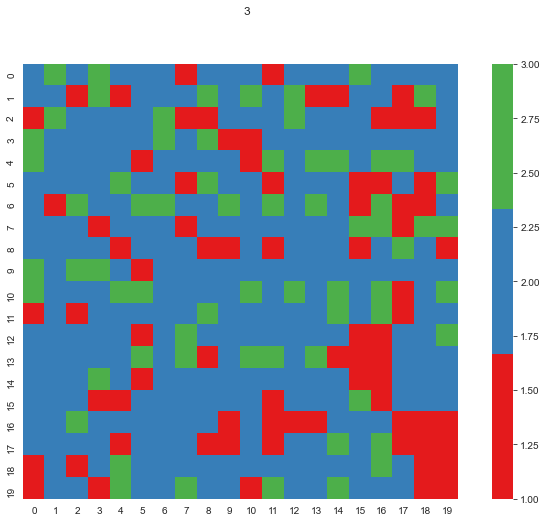

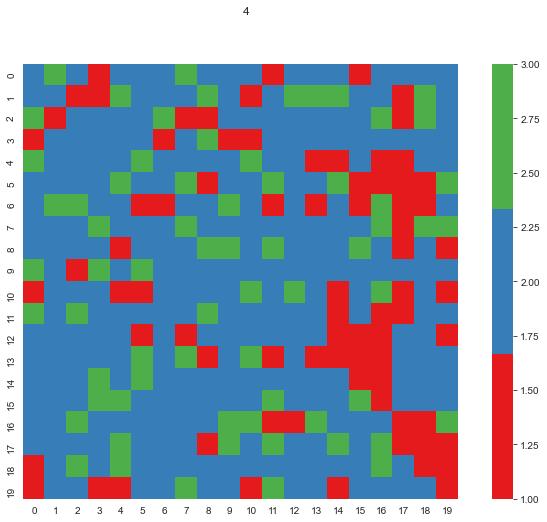

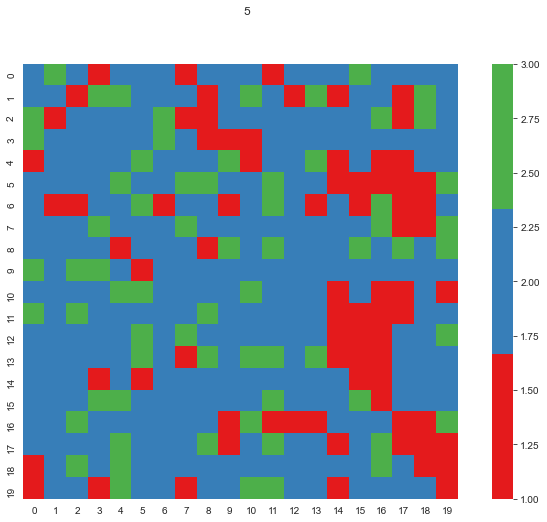

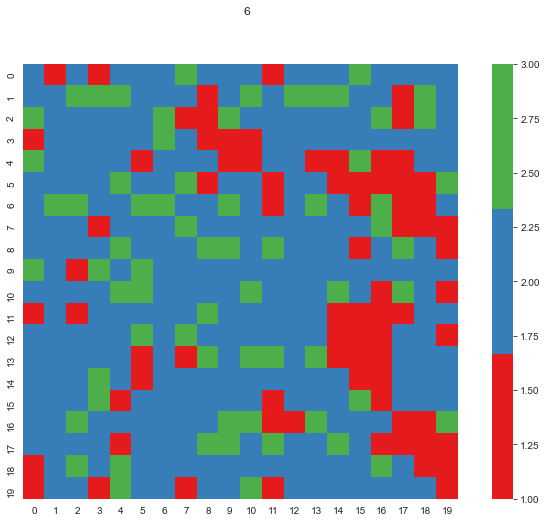

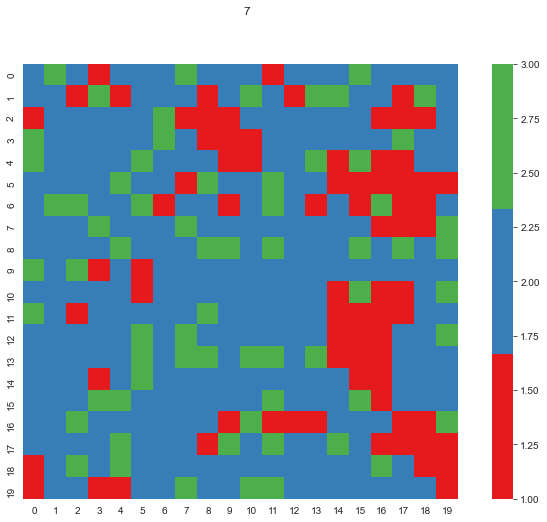

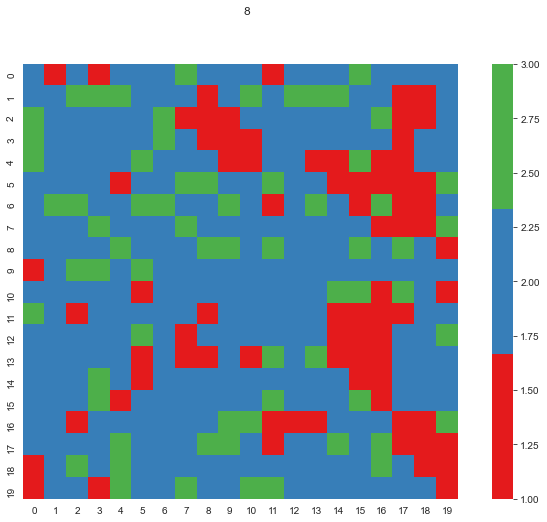

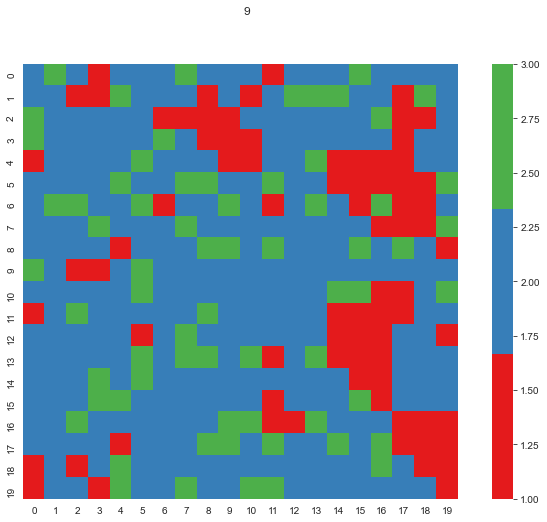

In [11]:
model = Schelling()

for i in range(10):
    fig, ax = plt.subplots()
    fig.suptitle(i)
    ax.set_aspect('equal')
    
    plot_model(model, ax, colors)
    plt.show()
    
    model.step()


We now have a basis version of Schelling seggregation working. We can play around with this model and already learn quite a bit. However, we can also expand the model a bit more.

## Assignment 3
We now have a working model. But we have so far relied only on visual inspection of the model. If we want to explore different tolerance levels, we need some useful statistics from the model as well. Making sense only of the grid is rather hard if we start running this model a few hundred times for different random seeds, different tolerance levels, and different neighborhood rules. A statistic that is easy to check is keeping track of how many agents are happy with their position. That is, they did not want to move to a new location. 

Implementing this requires a few changes:

* Agents need a happy attribute. This is set to True if the agent did not move. It is set to False otherwise.
* The model needs a data collector. This collector is called at each step of the model after all agents have moved and keeps track of the total number of happy agents.

Go ahead and update both the agent and the model.

In [12]:
def count_happy(model):
    happy = 0
    for agent in model.schedule.agents:
        if agent.happy:
            happy += 1
    return happy

class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : int
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=4, seed=None):
        super().__init__(seed=seed)
        self.height = height
        self.width = width
        self.density = density
        self.minority_fraction = minority_fraction

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(model_reporters={'happy':count_happy})

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < self.density:
                if self.random.random() < self.minority_fraction:
                    agent_color = Color.RED
                else:
                    agent_color = Color.BLUE

                agent = SchellingAgent((x, y), self, agent_color, tolerance_threshold)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)

In [13]:
class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    """

    def __init__(self, pos, model, color, tolerance_threshold):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = True

    def step(self):
        '''execute one step of the agent'''

        different = 0
        for neighbor in self.model.grid.neighbor_iter(self.pos, moore=True):
            if neighbor.color != self.color:
                different += 1
        
        meets_threshold = different <= self.tolerance_threshold
        
        if not meets_threshold:
            self.model.grid.move_to_empty(self)
            self.happy = False
        else:
            self.happy = True

In [14]:
model = Schelling()
for _ in range(30):
    model.step()

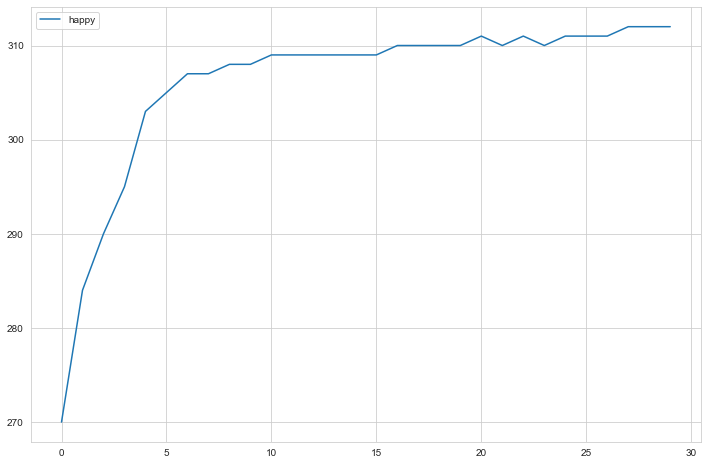

In [15]:
model.datacollector.get_model_vars_dataframe().plot()
plt.grid(True)
plt.show()

## Assignment 4
We used the ``move_to_empty`` method to move our agent. However, this method simply returns a random empty cell. We can make this a bit smarter by checking each free cell to see if moving there makes sense. That is, would the new neighborhood meet our preferences with respect to the different types of neighbors?

Below I have given the basic structure of this refined agent class. You have to fill in the `...` parts. Some more useful methods and attributes you might need are

* *grid.empties*; contains the collection of empty grid cells
* *grid.move_agent(agent, pos)*; method for moving an agent to a diffent grid cell. It also updates the position of the agent on the agent itself.
* the agent has a model attribute, the model has a grid attribute

Note that I have moved the checking of the threshold to its own seperate method which takes as input a position. In this way we can use the exact same code for checking whether an agent wants to move (we pass `self.pos`) or whether an empty cell meets the threshold (we pass an entry in `grid.empties`).

In [16]:
class SchellingAgent(Agent):
    """
    Schelling segregation agent
    
    Parameters
    ----------
    pos : tuple of 2 ints
          the x,y coordinates in the grid
    model : Model instance
    color : {Color.RED, Color.BLUE}
    tolerance_threshold : float
    
    """

    def __init__(self, pos, model, color, tolerance_threshold):
        super().__init__(pos, model)
        self.pos = pos
        self.color = color
        self.tolerance_threshold = tolerance_threshold
        self.happy = True

    def meets_threshold(self, pos):
        '''check if a given position meets the tolerance threshold
        
        Returns
        -------
        bool
        
        '''
        
        different = 0
        for neighbor in self.model.grid.neighbor_iter(pos, moore=True):
            if neighbor.color != self.color:
                different += 1
        
        return different <= self.tolerance_threshold
       
    def move_to_empty(self):
        '''move to an empty spot in the grid if the empty spot meets the tolerance threshold'''
        
        for entry in self.model.grid.empties:
            if self.meets_threshold(entry):
                self.model.grid.move_agent(self, entry)
                
            
    def step(self):
        '''execute one step of the agent'''
        if not self.meets_threshold(self.pos):
            self.move_to_empty()
            self.happy = False
        else:
            self.happy = True

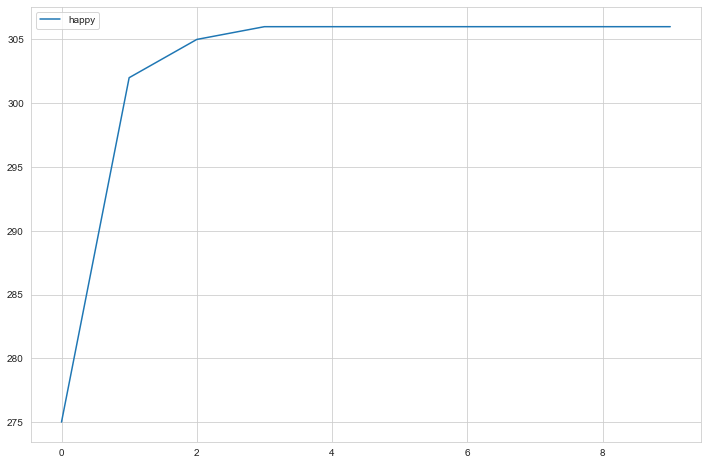

In [17]:
model = Schelling()

for i in range(10):
    model.step()

model.datacollector.get_model_vars_dataframe().plot()
plt.grid(True)
plt.show()


## Assignment 5
So far, we have run the model for the default values of the parameters `density`, `minority_fraction`, and `tolerance_threshold`. It is quite common in Agent Based Modelling to perform a parameter sweep where one runs the model over a range of parameterizations and analyse the results.

MESA support this with a so-called BatchRunner. See the [MESA tutorial](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html#batch-run) for details. In short, the BatchRunner allows you to specify a set of values for the parameters you want to vary, fixed values for parameters you don't want to vary, the number of iterations/replications for each run, the number of steps to run the model for, and what statistics to collect at the end of the run. The BatchRunner assumes that a `self.running` attribute is available on the model. This is used to indicate that the model has reached a stable equilibrium and will not change in any subsequent steps. If running is True, the model will still change. If running is False, the model has reached an equilibrium.

1. Let's update our model with this running attribute. What conditions must hold for the model to have reached equilibirum?

**Answer: The condition that must hold for the model to have reached equilibirum, is that all agents in the model are happy.**

2. Implement this condition and the running attribute. 
*Hint:* the scheduler has a `get_agent_count` method

3. Perform a batch run with the following settings. Visualize some results:
    * height and width fixed at 20
    * density varies from 0.8 to 0.9 with 0.025 increments
    * minority_fraction varies from 0.2 to 0.4 with 0.1 increments
    * tolerance_threshold varies from 2 to 4 with increment of 1
    * 5 replications
    * 50 steps

*Note:* there is a bug in the batchrunner were the column names in the dataframe after the batch run don't match the correct labels. 

In [18]:
class Schelling(Model):
    """
    Model class for the Schelling segregation model.
    
    Parameters
    ----------
    height : int
             height of grid
    width : int
            height of width
    density : float
            fraction of grid cells occupied
    minority_fraction : float
            fraction of agent of minority color
    tolerance_threshold : int
    
    Attributes
    ----------
    height : int
    width : int
    density : float
    minority_fraction : float
    schedule : RandomActivation instance
    grid : SingleGrid instance
    
    """

    def __init__(self, height=20, width=20, density=0.8, minority_fraction=0.2,
                 tolerance_threshold=4, seed=None):
        super().__init__(seed=seed)
        self.height = height
        self.width = width
        self.density = density
        self.minority_fraction = minority_fraction
        self.running = False

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(width, height, torus=True)
        self.datacollector = DataCollector(model_reporters={'happy':count_happy})

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if self.random.random() < self.density:
                if self.random.random() < self.minority_fraction:
                    agent_color = Color.RED
                else:
                    agent_color = Color.BLUE

                agent = SchellingAgent((x, y), self, agent_color, tolerance_threshold)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        """
        Run one step of the model.
        """
        self.schedule.step()
        self.datacollector.collect(self)
        
        if count_happy(self) == self.schedule.get_agent_count():
            self.running = False

In [19]:
from mesa.batchrunner import BatchRunner

fixed_params = {'width':20, 'height':20}
variable_params = {'density': [0.8, 0.825, 0.85, 0.875, 0.9],
                   'minority_fraction': [0.2, 0.3, 0.4],
                   'tolerance_threshold': [2, 3, 4]}

batch_run = BatchRunner(Schelling, variable_params, fixed_params,
                       iterations=5, max_steps=50,
                        model_reporters={'happy':count_happy})

batch_run.run_all()

225it [00:03, 60.50it/s]


In [20]:
results = batch_run.get_model_vars_dataframe()
results.head(10)

,minority_fraction,tolerance_threshold,density,Run,happy,width,height
0,0.8,0.2,2,0,321,20,20
1,0.8,0.2,2,1,312,20,20
2,0.8,0.2,2,2,335,20,20
3,0.8,0.2,2,3,314,20,20
4,0.8,0.2,2,4,316,20,20
5,0.8,0.2,3,5,321,20,20
6,0.8,0.2,3,6,330,20,20
7,0.8,0.2,3,7,314,20,20
8,0.8,0.2,3,8,330,20,20
9,0.8,0.2,3,9,325,20,20


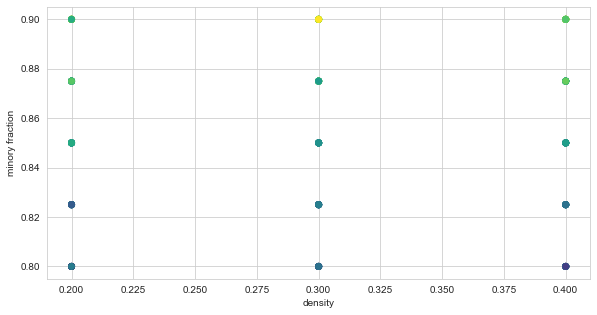

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(results.tolerance_threshold, results.minority_fraction, c=results.happy,
          cmap='viridis')
ax.set_aspect('equal')
ax.set_xlabel('density')
ax.set_ylabel('minory fraction')
plt.show()

In [22]:
Model??

Init signature: Model(*args: Any, **kwargs: Any) -> Any
Source:        
class Model:
    """ Base class for models. """

    def __new__(cls, *args: Any, **kwargs: Any) -> Any:
        """Create a new model object and instantiate its RNG automatically."""
        cls._seed = kwargs.get("seed", None)
        cls.random = random.Random(cls._seed)
        return object.__new__(cls)

    def __init__(self, *args: Any, **kwargs: Any) -> None:
        """ Create a new model. Overload this method with the actual code to
        start the model.

        Attributes:
            schedule: schedule object
            running: a bool indicating if the model should continue running

        """

        self.running = True
        self.schedule = None
        self.current_id = 0

    def run_model(self) -> None:
        """ Run the model until the end condition is reached. Overload as
        needed.

        """
        while self.running:
            self.step()

    def step(self) -> None:
    